# **Model Setup**

In [1]:
# install python packages required to solve model
!pip install pulp
!pip install gurobipy
from pulp import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# census tract information
ct = pd.read_csv('../data/2023Stocking_2010CT_HVI.csv', index_col = 0)

# zone information
zones = pd.read_csv('../data/Zones_Year_Assignment.csv', index_col = 0)
zones.columns = zones.columns.str.strip()
zones.set_index("Unique", inplace = True)

# set of zones
I = zones.index.tolist()
print(I)

# set of years in the 9-year cycle
Y = [i for i in range(9)]
print(Y)

# Zone ID → Community Board
community_boards = zones["Community Board"].to_dict()
print(community_boards)

# Zone ID → HVI
hvi_scores = zones["HVI"].to_dict()
print(hvi_scores)

# Zone ID → Tree planting potential
planning_potentials = zones["Planting Potential"].to_dict()
print(planning_potentials)

# list of zones with an HVI score of 4 or 5
high_HVI_zones = [i for i in I if zones.loc[i, "HVI 4/5 Count"] == 1]
print(high_HVI_zones)

min_hvi = zones["HVI"].min()
max_hvi = zones["HVI"].max()

# Scaling function of HVI scores
def hvi_weight(hvi):
    # aggressive
  # return (hvi / 5) ** 3
    # smoother curve
  # return 1 / (1 + np.exp(-(hvi - 3)))
    # HVI has linearly weighted
  return 1 + 4 * (hvi - min_hvi) / (max_hvi - min_hvi)


# time penalty encouraging high-HVI zones to be assigned earlier in the cycle
def time_weight(j):
  n_years = len(Y)
  return np.exp(-0.1 * (j - 1))

['101_1', '101_2', '101_3', '101_4', '101_5', '101_6', '101_7', '102_1', '102_2', '102_3', '102_4', '102_5', '103_1', '103_2', '103_3', '103_4', '103_5', '103_6', '104_1', '104_2', '104_3', '104_4', '104_5', '105_1', '105_10', '105_11', '105_12', '105_2', '105_3', '105_4', '105_5', '105_6', '105_7', '105_8', '105_9', '106_1', '106_2', '106_3', '106_4', '106_5', '107_1', '107_2', '107_3', '107_4', '108_1', '108_2', '108_3', '108_4', '108_5', '109_1', '109_2', '109_3', '109_4', '110_1', '110_2', '110_3', '111_1', '111_2', '111_3', '111_4', '111_5', '112_1', '112_2', '112_3', '112_4', '112_5', '112_6', '112_7', '201_1', '201_2', '201_3', '201_4', '202_1', '202_2', '203_1', '203_2', '203_3', '203_4', '204_1', '204_2', '204_3', '204_4', '205_1', '205_2', '205_3', '206_1', '206_2', '206_3', '207_1', '207_2', '207_3', '207_4', '207_5', '208_1', '208_10', '208_11', '208_2', '208_3', '208_4', '208_5', '208_6', '208_7', '208_8', '208_9', '209_1', '209_10', '209_2', '209_3', '209_4', '209_5', '20

In [2]:
ct

,OBJECTID,BoroName,BoroCT2010,PUMA,NTAName,NTACode,Shape_Leng,Borough,ONENYC_HVI,QUINTILES,...,TC2015.stem_count,TC2015.stump_count,TC2015.stocking_percent_deficit,TC2015.max_trees,TC2015.trees_to_add,TC2015.stocking_percent,TC2015.trees_to_add_70perc,2023TreesToAdd_70Perc,Block_Length_Sum,Trees_to_Add_per_1000_Feet
BoroCD,,,,,,,,,,,,,,,,,,,,,
1,1,Staten Island,5000900,3903,West New Brighton-New Brighton-St. George,SI22,7729.016600,5,-3.258102,1,...,269,6,0.236798,381,118,0.689928,83,91.0,24481.77128,3.717051
2,2,Staten Island,5002700,3903,Stapleton-Rosebank,SI37,6745.559749,5,-0.277956,3,...,295,14,0.056716,323,42,0.86894,30,14.0,17279.78767,0.810195
3,3,Staten Island,5002900,3903,Stapleton-Rosebank,SI37,10895.072440,5,-0.450569,3,...,544,9,0.447322,767,232,0.69782,162,103.6,48612.32223,2.131147
4,4,Staten Island,5003300,3903,Grymes Hill-Clifton-Fox Hills,SI08,18603.925060,5,-5.601794,1,...,354,10,0.798289,825,481,0.417008,337,347.2,57694.84794,6.017868
5,5,Staten Island,5003900,3903,Grymes Hill-Clifton-Fox Hills,SI08,11523.702270,5,-6.500620,1,...,334,3,0.236315,478,147,0.692722,103,118.3,30316.44182,3.902173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2310,2162,Brooklyn,3068600,4009,Georgetown-Marine Park-Bergen Beach-Mill Basin,BK45,6255.090822,3,-1.192089,2,...,222,2,0.095793,255,35,0.862266,25,23.1,15202.01371,1.519536
2311,2163,Brooklyn,3069800,4009,Georgetown-Marine Park-Bergen Beach-Mill Basin,BK45,27352.744280,3,0.088233,3,...,240,4,0.340751,405,169,0.582346,118,113.4,28652.36524,3.957788
2312,2164,Bronx,2037600,3702,Williamsbridge-Olinville,BX44,5797.771749,2,-0.364435,3,...,111,2,0.235094,185,76,0.587843,53,59.5,12219.44297,4.869289


In [3]:
zones

,BoroName,Community Board,Council District,Zone ID,Planting Potential,Year,HVI,HVI 4/5 Count,CT Count,Transition Contract,Transition Overlap %,New Year Assignment
Unique,,,,,,,,,,,,
101_1,Manhattan,101,1,1,146,1,1.3,0,1,MG-124M,100,8
101_2,Manhattan,101,1,2,141,1,2.7,0,2,0,0,2
101_3,Manhattan,101,1,3,172,4,1.0,0,1,0,0,2
101_4,Manhattan,101,1,4,154,4,1.3,0,8,MG-124M,43,5
101_5,Manhattan,101,1,5,249,7,3.0,0,1,MG-124M,100,8
...,...,...,...,...,...,...,...,...,...,...,...,...
503_2,Staten Island,503,50,2,1302,3,1.0,0,7,0,0,3
503_3,Staten Island,503,51,3,1295,2,1.0,0,7,0,0,2
503_4,Staten Island,503,51,4,1224,1,1.0,0,4,0,0,1


In [4]:
#additional fields for objective function

# Generate example proxy values
np.random.seed(42)  # for reproducibility
sim_pgi = {i: np.random.uniform(0, 1) for i in I}           # float [0, 1]
sim_tree_potential = {i: np.random.uniform(0.5, 1.5) for i in I}  # e.g., relative tree capacity

trees_per_1000ft = {i: np.random.normal(0.0, 1.0) for i in I}  # Higher = more physical planting opportunity
stocking_deficit = {i: np.random.normal(0.0, 5.0) for i in I} # Higher = more need for canopy fill-in

# number of cts in each zone; more cts -> more people -> larger impact
ct_count_weight = zones['CT Count'].to_dict()

def normalize_dict(d):
    vals = np.array(list(d.values()))
    return {k: (v - vals.min()) / (vals.max() - vals.min()) for k, v in d.items()}


# ONLY HVI Model

In [42]:
from ast import keyword
model4 = LpProblem("Tree_Planting_Scheduling", LpMaximize)

# DECISION VARIABLES
  # x[i,j] = 1 if zone i is assigned to year j
x = {(i, j): LpVariable(f"x_{i}_{j}", cat="Binary") for i in I for j in Y}

  # p[i,j] is the # of trees planted in zone i in year j
p = {
    (i, j): LpVariable(f"p_{i}_{j}", lowBound=0, upBound=planning_potentials[i])
    for i in I for j in Y
}


# CONSTRAINTS

# 1. Each zone must be scheduled exactly once across 9 years
for i in I:
    model4 += lpSum(x[i, j] for j in Y) == 1, f"VisitOnce_{i}"

# 2. CB-Year tree capacity constraint (≤1299 trees per CB per year)
unique_cbs = set(community_boards.values())
for cb in unique_cbs:
    cb_tracts = [i for i in I if community_boards[i] == cb]
    for j in Y:
        model4 += (
            lpSum(p[i,j] for i in cb_tracts) <= 1299,
            f"Capacity_CB{cb}_Year{j}"
        )


# 2.5. Handle CBs that exceed the 1300 limit
# PLEASE ADJUST overflow_cbs TO DATA
overflow_cbs = [412, 413, 414, 502, 503]

# Binary overflow flags
overflow_cb_var = {(cb, j): LpVariable(f"overflow_{cb}_{j}", cat="Binary")
               for cb in overflow_cbs for j in Y}

# Allow 1300 + delta if overflow_cb is used

# PLEASE ADJUST delta
delta = 1000
for cb in [412, 413, 414, 502, 503]:
    cb_tracts = [i for i in I if community_boards[i] == cb]
    for j in Y:
        model4 += (
            lpSum(p[i,j] for i in cb_tracts) <= 1299 + delta * overflow_cb_var[(cb, j)]
        )

# At most 1 CB overflow per year
for j in Y:
    model4 += lpSum(overflow_cb_var[(cb, j)] for cb in [412, 413, 414, 502, 503]) <= 1


# 3. Trees can only be planted in a given zone in a given year if it is assigned to that year
for i in I:
  for j in Y:
    model4 += p[i,j] <= planning_potentials[i] * x[i,j]


# 4. Visit at least one zone in one CB in every 3 years in the cycle
cb_set = set(community_boards.values())
for cb in cb_set:
    cb_tracts = [i for i in I if community_boards[i] == cb]
    if len(cb_tracts) > 2:
      for start in [0,3,6]:
        three_y_block = range(start, start+3)
        model4 += lpSum(x[i,j] for i in cb_tracts for j in three_y_block) >= 1
    else:
      model4 += lpSum(x[i,j] for i in cb_tracts for j in Y) == len(cb_tracts)


# 5. Balance constraint in # of Trees Planted
trees_per_year = {
    j: lpSum(p[i, j] for i in I)
    for j in Y
}

for j in Y:
  # cannot plant more than 20000 trees per year
  model4 += trees_per_year[j] <= 20000
  # best not to plant below 5000 trees per year, can change
  model4 += trees_per_year[j] >= 5000


# Pairwise deviation variables - dictionary mapping from pair of years (1-9)
# to their difference in # of trees planted (p[i,j])
pairwise_deviation_vars = {}

for j1 in Y:
    for j2 in Y:
        if j1 < j2:
            var_name = f"dev_{j1}_{j2}"
            pairwise_deviation_vars[(j1, j2)] = LpVariable(var_name, lowBound=0)

            # Absolute deviation constraints
            model4 += trees_per_year[j1] - trees_per_year[j2] <= pairwise_deviation_vars[(j1, j2)]
            model4 += trees_per_year[j2] - trees_per_year[j1] <= pairwise_deviation_vars[(j1, j2)]

# Cap on total deviation across all pairs
model4 += lpSum(pairwise_deviation_vars.values()) <= 10000, "TotalPairwiseDeviationCap"


# 6. For each zone, if it was visited within the last 'cooldown' years in the previous cycle,
# cannot plant it in the first 'cooldown - (9 - y_last)' years of the current cycle

# cooldown period in years
cooldown = 5

for unique_id, row in zones.iterrows():
  if pd.isnull(row["New Year Assignment"]):
        print(f"⏭️ Zone {i} skipped due to missing prior assignment")
        continue
  y_last = int(row["New Year Assignment"]) - 1
  earliest_allowed_year = min(8, y_last + cooldown - 9)

  if earliest_allowed_year > 8:
    print(f"⚠️ Zone {i}: Cooldown ends in year {earliest_allowed_year + 1}, beyond planning horizon.")

  for j in Y:
    if earliest_allowed_year > 8:
      print(f"⚠️ Zone {i} cannot be scheduled due to cooldown ending after last year.")
    if j < earliest_allowed_year:
      model4 += x[unique_id, j] == 0
      model4 += p[unique_id, j] == 0

# OBJECTIVE
model4 += lpSum(
    hvi_weight(hvi_scores[i]) *
    # ct_count_weight[i] *
    time_weight(j) *
    p[i, j]
    for i in I for j in Y
)

# SOLVE
from pulp import PULP_CBC_CMD
model4.solve(PULP_CBC_CMD(msg=True, timeLimit=600))
if LpStatus[model4.status] != "Optimal":
    print("WARNING: No feasible solution found. Status =", LpStatus[model4.status])
else:
    print("Optimal solution found! Objective =", value(model4.objective))

zones_per_year = np.zeros(9)
for var in model4.variables():
    if var.varValue is not None and var.varValue > 1e-10:
        name = var.name
        parts = name.split('_')
        var_type = parts[0]
        year = parts[-1]
        shifted_year = str(int(year) + 1)
        tract_id = "_".join(parts[1:-1])
        if var_type == "p":
          print(f"Census Tract: {tract_id} is assigned to Year: {shifted_year}, {round(var.varValue)} trees to plant")
        else:
          zones_per_year[int(year)] += 1

Optimal solution found! Objective = 329650.4961510925
Census Tract: 101_1 is assigned to Year: 9, 146 trees to plant
Census Tract: 101_2 is assigned to Year: 2, 141 trees to plant
Census Tract: 101_3 is assigned to Year: 9, 172 trees to plant
Census Tract: 101_4 is assigned to Year: 9, 154 trees to plant
Census Tract: 101_5 is assigned to Year: 4, 249 trees to plant
Census Tract: 101_6 is assigned to Year: 6, 128 trees to plant
Census Tract: 101_7 is assigned to Year: 2, 97 trees to plant
Census Tract: 102_1 is assigned to Year: 8, 131 trees to plant
Census Tract: 102_2 is assigned to Year: 2, 151 trees to plant
Census Tract: 102_3 is assigned to Year: 2, 160 trees to plant
Census Tract: 102_4 is assigned to Year: 6, 141 trees to plant
Census Tract: 102_5 is assigned to Year: 6, 151 trees to plant
Census Tract: 103_1 is assigned to Year: 7, 136 trees to plant
Census Tract: 103_2 is assigned to Year: 4, 145 trees to plant
Census Tract: 103_3 is assigned to Year: 2, 143 trees to plant
Ce

# **Save New Schedule**

In [53]:
import pandas as pd

assignments_x = []
assignments_p = []

for i in I:
    for j in Y:
        var_x = x[i, j]
        var_p = p[i, j]

        if var_x.varValue is not None and var_x.varValue > 0.5:
            assignments_x.append((i, j+1, var_x.varValue))

        if var_p.varValue is not None and var_p.varValue > 0.5:
            # (zone, year, trees)
            assignments_p.append((i, j+1, var_p.varValue))

start_year = 2036
end_year = 2045
assign_col = f"{start_year}-{end_year}_Assignment"
trees_col = f"{start_year}-{end_year}_trees_to_plant"

df_assign = pd.DataFrame(assignments_p, columns=['Zone', assign_col, trees_col])

df_updated = zones.merge(df_assign.set_index('Zone'),
                         left_index=True, right_index=True, how='left')

df_updated.to_csv(f"Zones_Year_Assignment_{start_year}_{end_year}.csv")

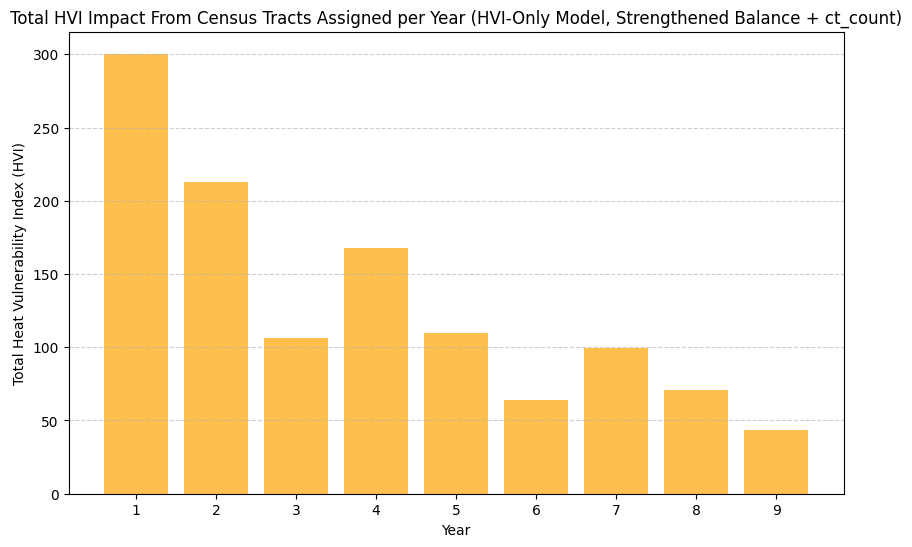

In [54]:
import matplotlib.pyplot as plt

assignments = []
for i in I:
    for j in Y:
        var = x[i,j]
        if var.varValue is not None and var.varValue > 0.5:
            assignments.append((i, j, hvi_scores[i]))

df_assign = pd.DataFrame(assignments, columns=['Tract', 'Year', 'HVI'])

hvi_per_year = df_assign.groupby('Year')['HVI'].sum().reset_index()
hvi_per_year['Year_adj'] = hvi_per_year['Year'] + 1
plt.figure(figsize=(10,6))
plt.bar(hvi_per_year['Year_adj'], hvi_per_year['HVI'], color='orange', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Total Heat Vulnerability Index (HVI)')
plt.title('Total HVI Impact From Census Tracts Assigned per Year (HVI-Only Model, Strengthened Balance + ct_count)')
plt.xticks(hvi_per_year['Year_adj'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

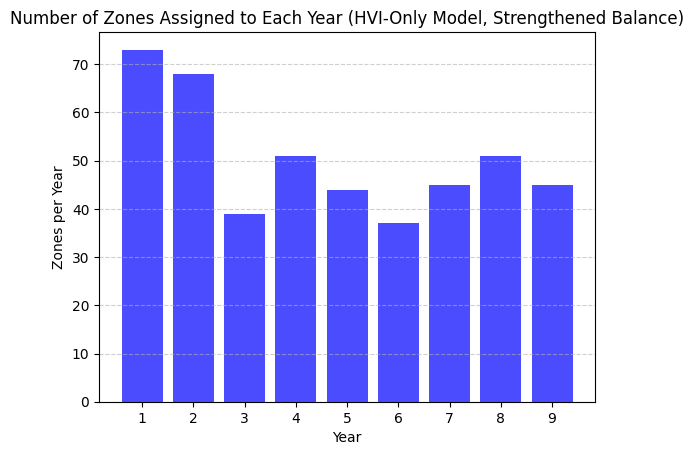

In [55]:
plt.bar(hvi_per_year['Year_adj'], zones_per_year, color='blue', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Zones per Year')
plt.title('Number of Zones Assigned to Each Year (HVI-Only Model, Strengthened Balance)')
plt.xticks(hvi_per_year['Year_adj'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

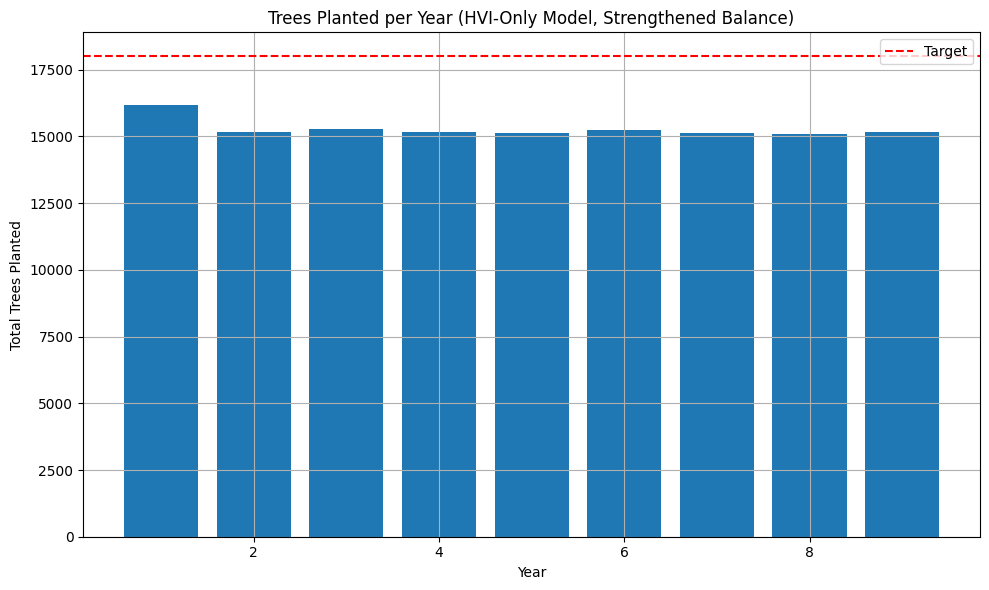

In [56]:
tree_totals = np.zeros(len(Y))
for (i, j) in p:
    if p[i, j].varValue is not None:
        tree_totals[j] += p[i, j].varValue

plt.figure(figsize=(10, 6))
plt.bar([y+1 for y in Y], tree_totals)
plt.axhline(18000, color='red', linestyle='--', label="Target")
plt.xlabel("Year")
plt.ylabel("Total Trees Planted")
plt.title("Trees Planted per Year (HVI-Only Model, Strengthened Balance)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

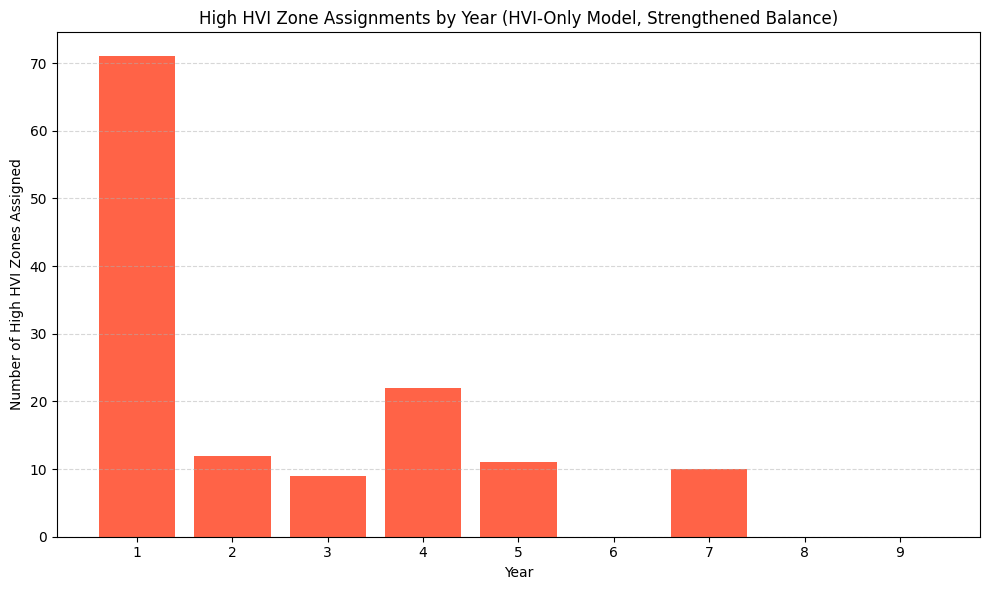

In [71]:
high_hvi_counts = np.zeros(len(Y))

# for var in model4.variables():
#     if var.name.startswith("x_") and var.varValue == 1:
#         parts = var.name.split("_")
#         i = "_".join(parts[1:-1])  # zone ID
#         j = int(parts[-1])         # year index

#         if hvi_scores[i] >= 4:
#             high_hvi_counts[j] += 1

for var in model4.variables():
    if var.name.startswith("x_") and var.varValue == 1:
        parts = var.name.split("_")
        i = "_".join(parts[1:-1])
        j = int(parts[-1]) + 1  # Planning year (1-based)

        hvi = round(hvi_scores[i])  # Consistent with second plot

        if hvi >= 4:
            high_hvi_counts[j - 1] += 1

years = np.arange(1, 10)

plt.figure(figsize=(10, 6))
plt.bar(years, high_hvi_counts, color="tomato")
plt.xlabel("Year")
plt.ylabel("Number of High HVI Zones Assigned")
plt.title("High HVI Zone Assignments by Year (HVI-Only Model, Strengthened Balance)")
plt.xticks(years)
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [72]:
high_hvi_zone_ids = [i for i, score in hvi_scores.items() if score >= 4]
print(f"Total high-HVI zones in data: {len(high_hvi_zone_ids)}")

# Count high-HVI zones assigned per year
high_HVI_counts = np.zeros(len(Y))  # assuming Y is your list/range of years

for var in model4.variables():
    if var.name.startswith("x_") and var.varValue == 1:
        parts = var.name.split("_")
        i = "_".join(parts[1:-1])  # zone id
        j = int(parts[-1])         # year index
        if hvi_scores.get(i, 0) >= 4:  # safer with get()
            high_HVI_counts[j] += 1

print("High-HVI zones assigned per year (model):")
for year, count in enumerate(high_HVI_counts, start=1):
    print(f"Year {year}: {int(count)} zones")

print(f"Total high-HVI zones assigned (model): {int(high_HVI_counts.sum())}")


Total high-HVI zones in data: 82
High-HVI zones assigned per year (model):
Year 1: 40 zones
Year 2: 8 zones
Year 3: 5 zones
Year 4: 17 zones
Year 5: 7 zones
Year 6: 0 zones
Year 7: 5 zones
Year 8: 0 zones
Year 9: 0 zones
Total high-HVI zones assigned (model): 82


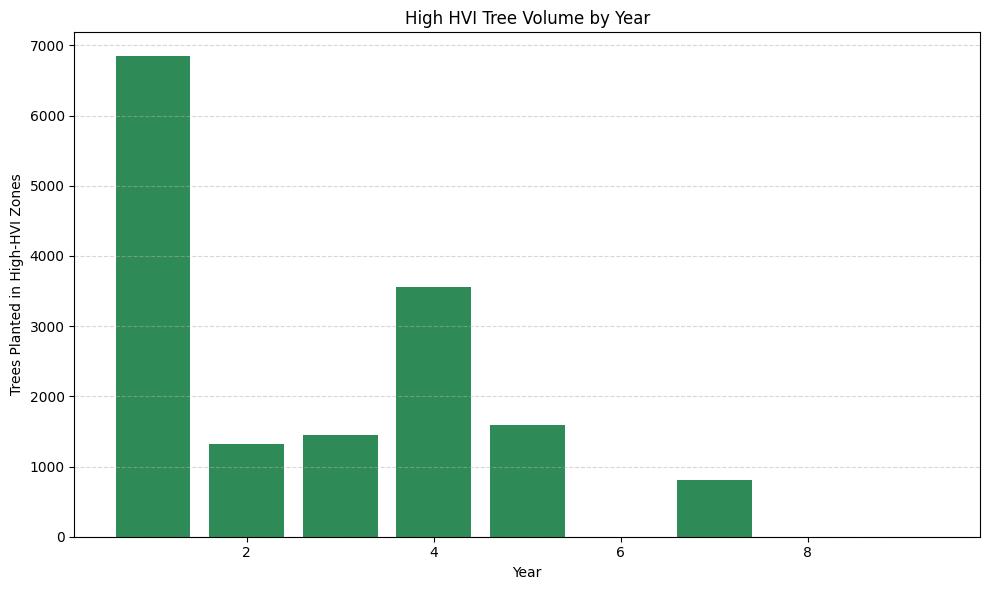

In [66]:
hvi_tree_volume = np.zeros(9)

for (i, j), var in p.items():
    if hvi_scores[i] >= 4 and var.varValue:
        hvi_tree_volume[j] += var.varValue

plt.figure(figsize=(10, 6))
plt.bar(years, hvi_tree_volume, color="seagreen")
plt.xlabel("Year")
plt.ylabel("Trees Planted in High-HVI Zones")
plt.title("High HVI Tree Volume by Year")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


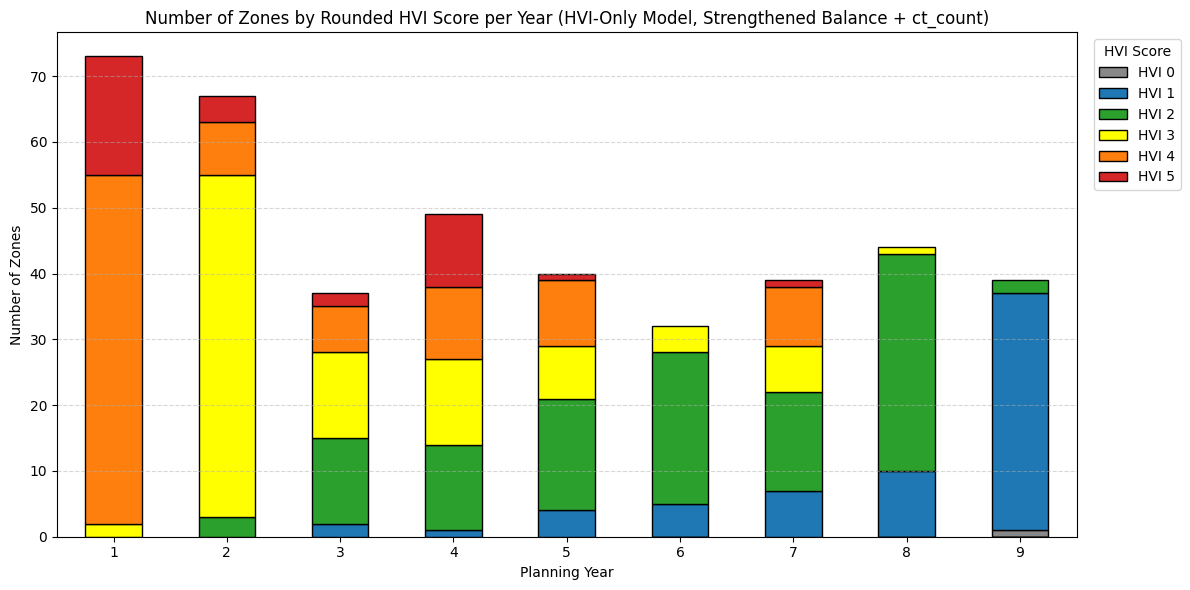

In [67]:
# Step 1: Extract assigned zones from model4
data = []

for var in model4.variables():
    if var.name.startswith("x_") and var.varValue == 1:
        # Parse variable name: x_{i}_{j}
        parts = var.name.split("_")
        i = "_".join(parts[1:-1])  # handle zone names with underscores
        j = int(parts[-1])
        hvi = hvi_scores[i]
        data.append({"Zone": i, "Year": j + 1, "HVI": hvi})

df = pd.DataFrame(data)

df['HVI_bin'] = df['HVI'].round().astype(int)

# Now define discrete levels based on the rounded values present
hvi_levels = sorted(df['HVI_bin'].unique())

zone_counts = (
    df.groupby(['Year', 'HVI_bin'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=hvi_levels, fill_value=0)
)

# Adjust color_map for the actual hvi_levels
color_map = {
    1: "#1f77b4",  # blue
    2: "#2ca02c",  # green
    3: "#FFFF00",  # yellow
    4: "#ff7f0e",  # orange
    5: "#d62728",  # red
}
colors = [color_map.get(hvi, "#888888") for hvi in hvi_levels]  # default gray if missing

# Plot as before
ax = zone_counts.plot(
    kind="bar",
    stacked=True,
    color=colors,
    figsize=(12, 6),
    edgecolor="black"
)

plt.title("Number of Zones by Rounded HVI Score per Year (HVI-Only Model, Strengthened Balance + ct_count)")
plt.xlabel("Planning Year")
plt.ylabel("Number of Zones")
plt.xticks(rotation=0)
plt.legend(
    title="HVI Score",
    labels=[f"HVI {hvi}" for hvi in hvi_levels],
    bbox_to_anchor=(1.01, 1),
    loc='upper left'
)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


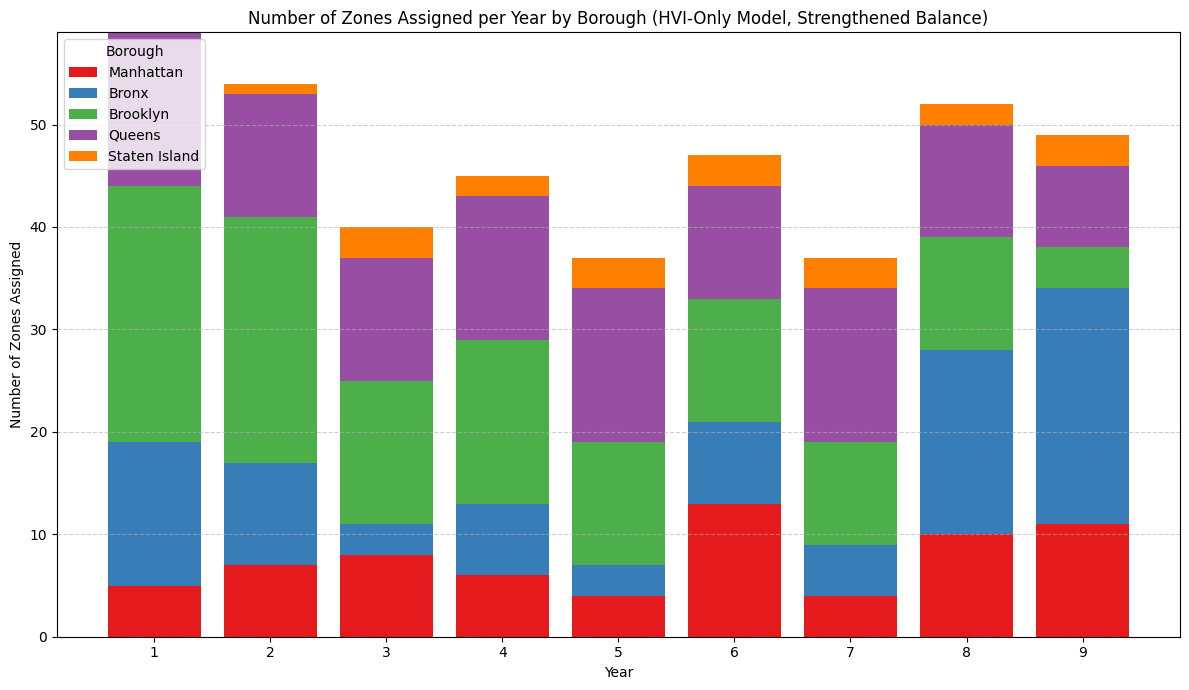

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Create a matrix to hold counts: rows = boroughs (5), cols = years (9)
borough_counts = np.zeros((5, 9))

# Go through the decision variables from the solved model
for var in model4.variables():  # or model3 if you're using that
    if var.name.startswith("x_") and var.varValue == 1:
        parts = var.name.split("_")
        tract_id = f"{parts[1]}_{parts[2]}"
        year = int(parts[3])  # 0-based

        if tract_id in community_boards:
            cb_code = community_boards[tract_id]
            borough = cb_code // 100  # Extract borough code (1–5)
            borough_counts[borough - 1, year] += 1  # Adjust for 0-index

# Plotting
years = np.arange(1, 10)  # 1–9
borough_labels = ["Manhattan", "Bronx", "Brooklyn", "Queens", "Staten Island"]
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']  # Distinct colors

plt.figure(figsize=(12, 7))
bottom = np.zeros(9)

# Stack each borough
for i in range(5):
    plt.bar(years, borough_counts[i], bottom=bottom, label=borough_labels[i], color=colors[i])
    bottom += borough_counts[i]

plt.xlabel("Year")
plt.ylabel("Number of Zones Assigned")
plt.title("Number of Zones Assigned per Year by Borough (HVI-Only Model, Strengthened Balance)")
plt.xticks(years)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Borough")
plt.tight_layout()
plt.show()

In [24]:
total_model_trees = sum(p[i, j].varValue for i in I for j in Y if p[i, j].varValue is not None)
print("Total trees planted by model:", total_model_trees)

max_possible_trees = sum(planning_potentials[i] for i in I)
print("Max possible trees if no constraints:", max_possible_trees)

Total trees planted by model: 137785.0
Max possible trees if no constraints: 138353


# **Checking Constraints**

In [25]:
# Check solution is feasible

for i in I:
    assigned_years = [j for j in Y if x[i, j].varValue == 1]
    assert len(assigned_years) == 1, f"Zone {i} assigned {len(assigned_years)} times"

for cb in overflow_cbs:
    for j in Y:
        total = sum(p[i, j].varValue for i in I if community_boards[i] == cb)
        allowed = 1299 + delta if overflow_cb_var[(cb, j)].varValue == 1 else 1299
        assert total <= allowed + 1e-3, f"CB {cb}, Year {j+1} exceeds allowed trees"

for unique_id, row in zones.iterrows():
    y_last = row["New Year Assignment"]
    if pd.isnull(y_last): continue
    y_last = int(y_last) - 1
    earliest_allowed = min(8, y_last + cooldown - 9)
    for j in Y:
        if j < earliest_allowed:
            assert x[unique_id, j].varValue == 0, f"Cooldown violated in zone {unique_id}, year {j+1}"

for j in Y:
    total = sum(p[i, j].varValue for i in I)
    assert 5000 <= total <= 20000, f"Year {j+1} out of bounds: {total} trees"

for j in Y:
    count = sum(overflow_cb_var[(cb, j)].varValue for cb in overflow_cbs)
    assert count <= 1 + 1e-3, f"More than one overflow CB in year {j+1}"

for cb in set(community_boards.values()):
    cb_tracts = [i for i in I if community_boards[i] == cb]
    if len(cb_tracts) > 2:
        for start in [0, 3, 6]:
            total = sum(x[i, j].varValue for i in cb_tracts for j in range(start, start+3))
            assert total >= 1, f"CB {cb} has no tracts in 3-year block starting year {start+1}"
    else:
        total = sum(x[i, j].varValue for i in cb_tracts for j in Y)
        assert abs(total - len(cb_tracts)) < 1e-3, f"CB {cb} with small size not fully scheduled"

for j in Y:
    for k in Y:
        if j < k:
            diff = abs(sum(p[i, j].varValue for i in I) - sum(p[i, k].varValue for i in I))
            assert diff <= 10000 + 1e-3, f"Year pair ({j+1}, {k+1}) exceeds deviation: {diff}"


# Current Solution

In [26]:
x = {(i, j): LpVariable(f"x_{i}_{j}", cat="Binary") for i in I for j in Y}

  # p[i,j] is the # of trees planted in zone i in year j
p = {
    (i, j): LpVariable(f"p_{i}_{j}", lowBound=0, upBound=planning_potentials[i])
    for i in I for j in Y
}

manual_objective = 0

for unique_id, row in zones.iterrows():
    assigned_year = row["New Year Assignment"]
    num_trees = row["Planting Potential"]
    hvi = row["HVI"]

    if pd.notnull(assigned_year) and pd.notnull(num_trees):
        assigned_year = int(assigned_year) - 1

        for y in Y:
          x_val = 1 if y == assigned_year else 0
          p_val = num_trees if y == assigned_year else 0

          x[(unique_id, y)].setInitialValue(x_val)

          x[(unique_id, y)].varValue = x_val

          p[(unique_id, y)].setInitialValue(p_val)
          p[(unique_id, y)].varValue = p_val


        hvi_w = hvi_weight(hvi)
        time_w = time_weight(assigned_year)

        manual_objective += hvi_w * time_w * num_trees
        print(f"Census Tract: {unique_id} is assigned to Year: {assigned_year+1}, {int(num_trees)} trees to plant")

# Print total objective
print("\nManual assignment total objective value:", round(manual_objective, 2))

# Compare to model
from pulp import value
print("Model solution objective value:", round(value(model4.objective), 2))

Census Tract: 101_1 is assigned to Year: 8, 146 trees to plant
Census Tract: 101_2 is assigned to Year: 2, 141 trees to plant
Census Tract: 101_3 is assigned to Year: 2, 172 trees to plant
Census Tract: 101_4 is assigned to Year: 5, 154 trees to plant
Census Tract: 101_5 is assigned to Year: 8, 249 trees to plant
Census Tract: 101_6 is assigned to Year: 5, 128 trees to plant
Census Tract: 101_7 is assigned to Year: 5, 97 trees to plant
Census Tract: 102_1 is assigned to Year: 8, 131 trees to plant
Census Tract: 102_2 is assigned to Year: 2, 151 trees to plant
Census Tract: 102_3 is assigned to Year: 5, 160 trees to plant
Census Tract: 102_4 is assigned to Year: 5, 141 trees to plant
Census Tract: 102_5 is assigned to Year: 5, 151 trees to plant
Census Tract: 103_1 is assigned to Year: 8, 136 trees to plant
Census Tract: 103_2 is assigned to Year: 5, 145 trees to plant
Census Tract: 103_3 is assigned to Year: 2, 143 trees to plant
Census Tract: 103_4 is assigned to Year: 2, 134 trees to